In [262]:
%pylab inline

import biff
from pygadgetreader import *
from astropy import constants
from astropy import units
from scipy import interpolate
from octopus import leapfrog


G1 = constants.G
G1 = G1.to(units.kpc**3/(units.Msun * units.Gyr**2))

G_c = constants.G
G_c = G_c.to(units.kiloparsec**3 / (units.s**2 * units.Msun)) # 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [63]:
font = {'size':16, 'family':'serif'}
plt.matplotlib.rc('font', **font)

In [4]:
## Code taken from (https://github.com/adrn/biff/blob/master/notebooks/Plummer%20test.ipynb)
def STnlm(xyz, mass, rs, n_max, l_max):
    nmax = n_max
    lmax = l_max

    Snlm = np.zeros((nmax+1,lmax+1,lmax+1))
    Tnlm = np.zeros((nmax+1,lmax+1,lmax+1))

    nlms = []

    for n in range(nmax+1):
        for l in range(lmax+1):
            for m in range(l+1):
                nlms.append([n,l,m])

    for nlm in nlms:
        n,l,m = nlm
        S,T = biff.compute_coeffs_discrete(np.double(xyz), np.double(mass/100.0), nlm, rs)
        Snlm[n,l,m] = S
        Tnlm[n,l,m] = T
    return Snlm, Tnlm, nlms

In [99]:
def evaluate_coeff(snap_n, rs, n_max, l_max):
    LMCMW_pos = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_{:03d}.hdf5'.format(snap_n), 'pos', 'dm')
    LMCMW_mass = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_{:03d}.hdf5'.format(snap_n), 'mass', 'dm')
    SMWLMC, TMWLMC, nlmsMWLMC = STnlm(LMCMW_pos, LMCMW_mass, rs, n_max, l_max)
    SMWLMC = reshape(SMWLMC, (size(SMWLMC)))
    TMWLMC = reshape(TMWLMC, (size(TMWLMC)))
    return SMWLMC, TMWLMC

In [249]:
def ST_interpol(nmax, lmax, n_snap, h, dt_snap):
    #n_snap = 8
    #nmax = 1
    #lmax = 1
    #dt_snap = 0.02
    #h = 0.001
    # Number of coefficients Snlm / Tnlm
    n_coeff = ((nmax+1)*(lmax+1)*(lmax+1))
    # S, T matrices, rows: time / cols: Number of coefficients
    S_matrix = np.zeros((n_snap, n_coeff))
    T_matrix = np.zeros((n_snap, n_coeff))

    # Filling the matrix with the coefficients form the N-body sim.
    for i in range(n_snap):
        S_matrix[i], T_matrix[i] = evaluate_coeff(i, 40.3, nmax, lmax)

    # time: Time between every snapshot
    time = np.linspace(0, dt_snap*(n_snap-1), n_snap)
    # N_interp: Number of times in the interpolation (this depent in the resolution of the leapfrog integration h)
    N_interp = (dt_snap*(n_snap-1)/h)+1
    # t: Time between every time step in the interpolation
    t = np.linspace(0, dt_snap*(n_snap-1), N_interp)

    #S_matrix_interp: Matrix with the new interpolated Snlm (times, Svalues)
    S_matrix_interp = np.zeros((len(t), n_coeff))
    T_matrix_interp = np.zeros((len(t), n_coeff))
    # Interpolating 
    for i in range(n_coeff):
        fs = interpolate.interp1d(time, S_matrix[:,i], kind='linear')
        ft = interpolate.interp1d(time, T_matrix[:,i], kind='linear')
        S_matrix_interp[:,i]= fs(t)
        T_matrix_interp[:,i]= ft(t)
    
    S_new = reshape(S_matrix_interp, (N_interp, nmax+1, lmax+1, lmax+1))
    T_new = reshape(T_matrix_interp, (N_interp, nmax+1, lmax+1, lmax+1))
    
    return S_new, T_new
    


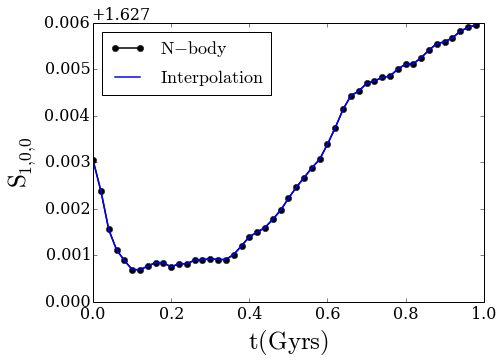

In [129]:
figure(figsize=(7, 5))
plot(time, S_matrix[:,0], 'o', lw=1.5, c='k', ls='-', label='$\mathrm{N-body}$')
plot(t, S, lw=1.5, c='b', label='$\mathrm{Interpolation}$')
legend(loc='best', fontsize=18)
xlabel('$\mathrm{t(Gyrs)}$', fontsize=25)
ylabel('$\mathrm{S_{1,0,0}}$', fontsize=25)


In [250]:
S_test, T_test = ST_interpol(1, 1, 2, 0.001, 0.2)

Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass


In [261]:
S_test[0]

array([[[  1.63004232e+00,   0.00000000e+00],
        [  1.80279471e-02,  -1.30883010e-03]],

       [[  2.72801892e-02,   0.00000000e+00],
        [  1.10641298e-02,  -1.83360879e-03]],

       [[  1.05716837e-02,   0.00000000e+00],
        [  5.74419581e-03,  -5.01678632e-04]]])

In [255]:
LMCMW_pos = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_000.hdf5', 'pos', 'dm')
LMCMW_mass = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_000.hdf5', 'mass', 'dm')
SMWLMC, TMWLMC, nlmsMWLMC = STnlm(LMCMW_pos, LMCMW_mass, 40.3, 2, 1)

Returning DM    Positions
Returning DM    Mass


In [260]:
SMWLMC

array([[[  1.63004232e+00,   0.00000000e+00],
        [  1.80279471e-02,  -1.30883010e-03]],

       [[  2.72801892e-02,   0.00000000e+00],
        [  1.10641298e-02,  -1.83360879e-03]],

       [[  1.05716837e-02,   0.00000000e+00],
        [  5.74419581e-03,  -5.01678632e-04]]])

In [270]:
S_1, T_1 = ST_interpol(5, 5, 21, 0.001, 0.2)

Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass


In [271]:
t_hex1_c, x_hex1_c, y_hex1_c, z_hex1_c, vx_hex1_c, vy_hex1_c, vz_hex1_c = leapfrog.integrate_biff_t(0, 10, 0, 100, 0, 0, 0.4, S_1, T_1, 5, 5, G1.value, 1.55E12, 40.85)


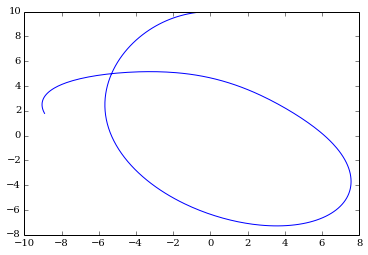

In [272]:
plot(x_hex1_c, y_hex1_c)
